In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage as sk
import skimage.io as skio
from PIL import ImageEnhance

In [2]:
def ncc(matA, matB):
    sum = 0
    aNorm = np.divide(matA, np.linalg.norm(matA, axis=0).T)
    bNorm = np.divide(matB, np.linalg.norm(matB, axis=0).T)
    # print(aNorm.shape)
    sum += np.sum(np.einsum('ij, ij -> i', aNorm, bNorm))
    # for y in range(0, matA.shape[0]):
    #     matAVec = aNorm[y, :]
    #     matBVec = aNorm[y, :]
    #     sum += np.dot(np.divide(matAVec, aNorm), np.divide(matBVec, bNorm, where= bNorm!=0))
    aNorm = np.divide(matA, np.linalg.norm(matA, axis=1)[:, None])
    bNorm = np.divide(matB, np.linalg.norm(matB, axis=1)[:, None])
    # print(aNorm.shape)
    sum += np.sum(np.einsum('ij, ij -> j', aNorm, bNorm))
    # for x in range(0, matA.shape[1]):
    #     matAVec = matA[:, x]
    #     matBVec = matB[:, x]
    #     aNorm = np.linalg.norm(matAVec)
    #     bNorm = np.linalg.norm(matBVec)
    #     sum += np.dot(np.divide(matAVec, aNorm), np.divide(matBVec, bNorm, where= bNorm!=0))
    return sum
    # return np.corrCoef(matA, matB)

def shift_frame(x_shift, y_shift, matA, zeroPad = False):
    if x_shift < 0:
        if y_shift < 0:
            return np.pad(matA[:y_shift, :x_shift], ((0, -y_shift), (0, -x_shift)), mode="constant") if zeroPad else matA[:y_shift, :x_shift]
        else:
            return np.pad(matA[y_shift: ,:x_shift], ((y_shift, 0), (0, -x_shift)), mode="constant") if zeroPad else matA[y_shift: ,:x_shift]
    else:
        if y_shift < 0:
            return np.pad(matA[:y_shift ,x_shift:], ((0, -y_shift), (x_shift, 0)), mode="constant") if zeroPad else matA[:y_shift ,x_shift:]
        else:
            return np.pad(matA[y_shift: ,x_shift:], ((y_shift, 0), (x_shift, 0)), mode="constant") if zeroPad else matA[y_shift: ,x_shift:]

In [3]:
def find_shift(baseFrame, layerFrame, pyramidLayer):
    if (pyramidLayer > 1):
        shiftRange = find_shift(sk.transform.rescale(baseFrame, 0.5, anti_aliasing = True), sk.transform.rescale(layerFrame, 0.5, anti_aliasing = True), pyramidLayer - 1)
    shift = []
    # bestFrame = []
    maxCorr = 0

    print("Pyramid layer/img shape", pyramidLayer, baseFrame.shape)
    if (pyramidLayer > 1):
        print("shiftRange: ", shiftRange[-2])
        highXRange = shiftRange[-1][0] * 2 + max(np.floor(baseFrame.shape[1] / 2 * 0.005).astype(int) + 1, 5)
        lowXRange = shiftRange[-1][0] * 2 - max(np.floor(baseFrame.shape[1] / 2 * 0.005).astype(int) + 1, 5)
        highYRange = shiftRange[-1][1] * 2 + max(np.floor(baseFrame.shape[0] / 2 * 0.005).astype(int) + 1, 5)
        lowYRange = shiftRange[-1][1] * 2 - max(np.floor(baseFrame.shape[0] / 2 * 0.005).astype(int) + 1, 5)
    else:
        highXRange = max(np.floor(baseFrame.shape[1] * 0.04).astype(int), 25)
        lowXRange = -highXRange
        highYRange = max(np.floor(baseFrame.shape[0] * 0.04).astype(int), 25)
        lowYRange = -highYRange
    print(f"roll range x/y: {lowXRange} - {highXRange-1}, {lowYRange} - {highYRange-1}")
    
    for y in range(lowYRange, highYRange):
        yShifted = np.roll(layerFrame, y, axis=0)
        for x in range(lowXRange, highXRange):
            xShifted = np.roll(yShifted, x, axis=1)
            layerFrameCropped = shift_frame(x, y, xShifted)
            baseFrameCropped = shift_frame(x, y, baseFrame)
            corrScore = ncc(baseFrameCropped, layerFrameCropped)
            # print(y,x)
            # print(corrScore)
            if corrScore > maxCorr:
                print(corrScore, y, x)
                maxCorr = corrScore
                # print(corrScore)
                # bestFrame = [baseFrameCropped, layerFrameCropped]
                shift.append([x,y])
             
    # matchedFrame = np.stack((bestFrame[0], np.empty_like(bestFrame[0]), np.empty_like(bestFrame[0])), axis=2)   
    # matchedFrame = cv2.normalize(np.sum(bestFrame, axis=0), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    # fig, axs = plt.subplots(1, 2, figsize=(20, 30))
    # axs[0].imshow(bestFrame[0], cmap='gray', vmin=0, vmax=1)
    # axs[1].imshow(bestFrame[1], cmap='gray', vmin=0, vmax=1)
    # plt.show()
    return shift
    

In [34]:
# name of the input file
imname = './data/monastery.jpg'

# read in the image
im = skio.imread(imname, cv2.IMREAD_GRAYSCALE)
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)

# separate color channels
b = im[:height]
g = im[height: 2*height]
r = im[2*height: 3*height]

v_border = int(r.shape[0]*0.1)
h_border = int(r.shape[1]*0.1)
r_cropped = sk.util.img_as_float(r[v_border:-v_border, h_border:-h_border])
b_cropped = sk.util.img_as_float(b[v_border:-v_border, h_border:-h_border])
g_cropped = sk.util.img_as_float(g[v_border:-v_border, h_border:-h_border])
rgb = np.array([r_cropped, g_cropped, b_cropped])


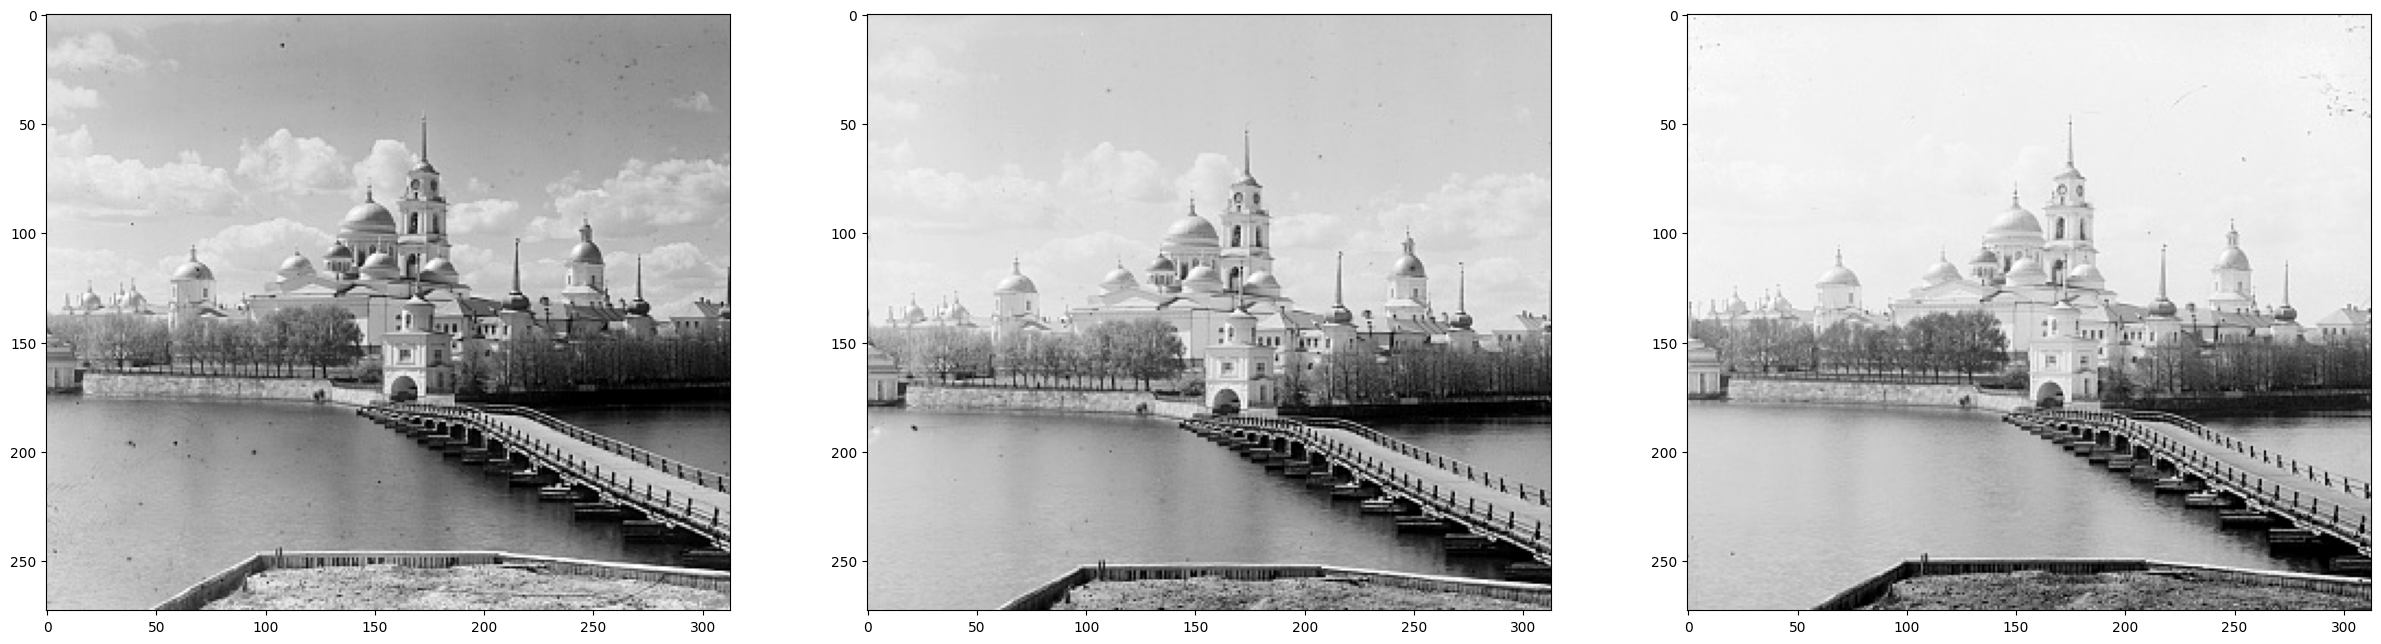

In [35]:
for i in range(0, 3):
    img_adj = rgb[i]
    blackpoint = np.percentile(img_adj, 1)
    # print(blackpoint)
    img_adj = np.clip(img_adj - blackpoint, 0, 1).astype(np.float64)
    
    img_adj = 1 - img_adj
    img_adj = 1.2 * img_adj
    img_adj = 1 - img_adj

    rgb[i] = cv2.normalize(img_adj, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
r_cropped = rgb[0]
g_cropped = rgb[1]
b_cropped = rgb[2]

fig, axs = plt.subplots(1, 3, figsize=(30, 40))
axs[0].imshow(r_cropped, cmap='gray', vmin=0, vmax=1)
axs[1].imshow(g_cropped, cmap='gray', vmin=0, vmax=1)
axs[2].imshow(b_cropped, cmap='gray', vmin=0, vmax=1)
plt.show()

In [36]:
shift = []
shift.append(find_shift(b_cropped, g_cropped, 4))
print()
shift.append(find_shift(b_cropped, r_cropped, 4))
    
print(shift[0][-1], shift[1][-1])

Pyramid layer/img shape 1 (34, 39)
roll range x/y: -25 - 24, -25 - 24
21.375584487929224 -25 -25
22.30749661438254 -25 -24
23.265788624046145 -25 -23
24.260989967746465 -25 -22
25.281270321423236 -25 -21
26.306231356237735 -25 -20
27.328139081726864 -25 -19
28.349312067828638 -25 -18
29.373361339402326 -25 -17
30.392953091785728 -25 -16
31.405044283536128 -25 -15
32.41347837470518 -25 -14
33.416278516282304 -25 -13
34.406965563209894 -25 -12
35.38392575202627 -25 -11
36.343071449387566 -25 -10
37.3124807250101 -25 -9
38.30818270234506 -25 -8
39.30415544131909 -25 -7
40.300707802267425 -25 -6
41.299406574245964 -25 -5
42.299102936543996 -25 -4
43.297159135873144 -25 -3
44.29603382392571 -25 -2
45.29688131897026 -25 -1
46.300742463724305 -25 0
46.30207433544547 -24 -1
47.30354734962592 -24 0
48.091605840366356 -23 0
48.556096169781824 -22 0
49.32069038671914 -21 0
50.20643157794392 -20 0
50.22482841044901 -19 -1
51.234113400559124 -19 0
51.30752587741902 -18 -1
52.308682452764636 -18 0
5

(273, 313) (273, 313) (273, 313)


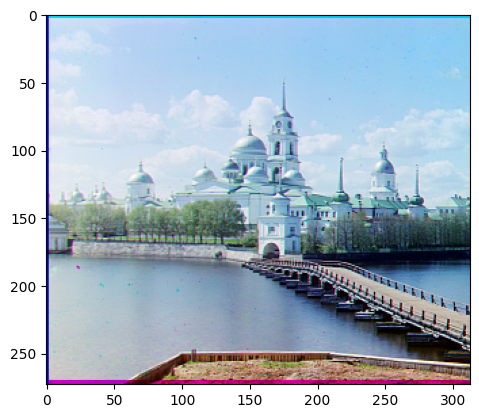

In [37]:
finalShift = np.array([shift[0][-1], shift[1][-1]])

# counter = 0
# for i in shift[0]:
#     b = b_cropped
#     g = shift_frame(i[0], i[1], np.roll(g_cropped, (i[0], i[1]), axis=(1, 0)), zeroPad=True)
#     r = r_cropped

#     bgr = np.array([r,g,b])
#     colorized= np.stack((r,g,b), axis=2)
#     plt.imshow(colorized)
#     plt.savefig(f'./Writeup/ImgData/cathedral/ani/frame_{counter}.jpg')
#     counter += 1

# for i in shift[1]:
#     b = b_cropped
#     g = shift_frame(finalShift[0, 0], finalShift[0, 1], np.roll(g_cropped, (finalShift[0, 0], finalShift[0, 1]), axis=(1, 0)), zeroPad=True)
#     r = shift_frame(i[0], i[1], np.roll(r_cropped, (i[0], i[1]), axis=(1, 0)), zeroPad=True)

#     bgr = np.array([r,g,b])
#     colorized= np.stack((r,g,b), axis=2)
#     plt.imshow(colorized)
#     plt.savefig(f'./Writeup/ImgData/cathedral/ani/frame_{counter}.jpg')
#     counter += 1


b = b_cropped
g = shift_frame(finalShift[0, 0], finalShift[0, 1], np.roll(g_cropped, (finalShift[0, 0], finalShift[0, 1]), axis=(1, 0)), zeroPad=True)
r = shift_frame(finalShift[1, 0], finalShift[1, 1], np.roll(r_cropped, (finalShift[1, 0], finalShift[1, 1]), axis=(1, 0)), zeroPad=True)
print(r.shape, g.shape, b.shape)

bgr = np.array([r,g,b])
colorized= np.stack((r,g,b), axis=2)
plt.imshow(colorized)



In [44]:
maxShifts = np.clip(np.max(finalShift, axis=0), a_min = 0, a_max = None)
minShifts = np.clip(np.min(finalShift, axis=0), a_min = None, a_max = 0)

if minShifts[0] < 0:
    if minShifts[1] < 0:
        bgr = bgr[:, maxShifts[1]:minShifts[1], maxShifts[0]:minShifts[0]]
    else:
        bgr = bgr[:, maxShifts[1]:, maxShifts[0]:minShifts[0]]
else:
    if minShifts[1] < 0:
        bgr = bgr[:, maxShifts[1]:minShifts[1], maxShifts[0]:]
    else:
        bgr = bgr[:, maxShifts[1]:, maxShifts[0]:]

In [45]:
finalShift

array([[ 2, -3],
       [ 2,  3]])

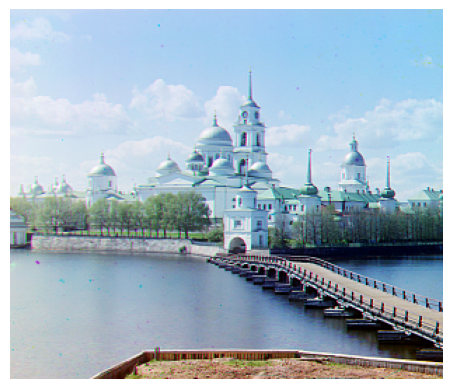

In [49]:
# colorized = (1 - np.stack((bgr[0],bgr[1],bgr[2]), axis=2))
colorized = (np.stack((bgr[0],bgr[1],bgr[2]), axis=2))
colorized = cv2.normalize(colorized, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
plt.axis('off')
plt.imshow(colorized)
# plt.savefig(f'./Writeup/ImgData/monastery_colourized.jpg', bbox_inches='tight', pad_inches=0)